<a href="https://colab.research.google.com/github/nasa-gcn/circulars-nlp-paper/blob/main/topic-modeling/notebooks/observation_based_topic_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Topic Modelling Pipeline for the NASA GCN Platform with Pre-Defined Observation-Based Topic Labels**
The aim of this project is to leverage the power of BERTopic to build a transformer powered topic model for the NASA GCN circular database.

It is recommended to run this notebook in Google Colab.

To get results consistent with those reported in the paper, it is recommended to run each section in this notebook sequentially and only once. Re-running it without restarting the runtime may yield slightly different results in certain sections due to the inherently stochastic nature of some of the agorithms used. We also recommend using Google Colab's T4 GPU runtime, which is what we used in our work. This is not a requirement and any GPU runtime may suffice, however using a different runtime may once again produce minor deviations from the results in our paper, as variations in hardware configurations can affect the outcomes of some of the algorithms used.

#STEP 1: Download And Unzip Necessary Files From Our Github Repo

In [ ]:
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/archive_2025.json.tar.gz -O /content/archive_2025.json.tar.gz
!wget https://raw.githubusercontent.com/nasa-gcn/circulars-nlp-paper/main/data/custom_stopwords.txt -O /content/custom_stopwords.txt
# !wget https://github.com/nasa-gcn/circulars-nlp-paper/tree/main/topic-modeling/fine-tuned-models/observational_tuned_mini_lm_epoch1.zip -O /content/tuned_mini_lm_1.zip
# !wget https://github.com/nasa-gcn/circulars-nlp-paper/tree/main/topic-modeling/fine-tuned-models/observational_tuned_mini_lm_epoch2.zip -O /content/tuned_mini_lm_2.zip
# !wget https://github.com/nasa-gcn/circulars-nlp-paper/tree/main/topic-modeling/fine-tuned-models/observational_tuned_mini_lm_epoch3.zip -O /content/tuned_mini_lm_3.zip

--2025-06-14 20:32:39--  https://github.com/ronitagarwala01/NASA_GCN_NLP/raw/main/data/archive_2025.json.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive_2025.json.tar.gz [following]
--2025-06-14 20:32:39--  https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive_2025.json.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27323287 (26M) [application/octet-stream]
Saving to: ‘/content/archive_2025.json.tar.gz’

/content/archive_20 100%[===================>]  26.06M  --.-KB/s    in 0.1s    

2025-06-14 20:32:40 (254

In [ ]:
# !unzip /content/tuned_mini_lm_1.zip -d /content/tuned_mini_lm_1
# !mv /content/tuned_mini_lm_1/tuned_mini_lm_1/* /content/tuned_mini_lm_1
# !rm -rf /content/tuned_mini_lm_1/tuned_mini_lm_1

# !unzip /content/tuned_mini_lm_2.zip -d /content/tuned_mini_lm_2
# !mv /content/tuned_mini_lm_2/tuned_mini_lm_2/* /content/tuned_mini_lm_2
# !rm -rf /content/tuned_mini_lm_2/tuned_mini

# !unzip /content/tuned_mini_lm_3.zip -d /content/tuned_mini_lm_3
# !mv /content/tuned_mini_lm_3/tuned_mini_lm_3/* /content/tuned_mini_lm_3
# !rm -rf /content/tuned_mini_lm_3/tuned_mini_lm_3

#Step 2: Install Necessary Libraries

In [ ]:
%pip install bertopic==0.16.2 -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 848.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00


#Step 3: Extract GCN Circulars

In [ ]:
'''
Extract circular JSONs from tar file.
'''
import tarfile
import os

with tarfile.open('./archive_2025.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') # Store all file names as strings in dir

# Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')

Number of Circular JSONs: 40506

First JSON path is: ./all_gcn_circulars/archive.json/-1.json


In [ ]:
'''
Extract circular bodies from JSON list.
'''
import json

circulars = []
circular_bodies = []
time_stamps = []
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])
    time_stamps.append(data["createdOn"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

The first circular is:
 {'subject': 'Possible new SGR from US Naval Observatory', 'editedOn': 1720124028651, 'version': 4, 'createdOn': 874022400000, 'editedBy': 'Vidushi Sharma at NASA GSFC/UMBC <vidushi.sharma@nasa.gov> on behalf of Tyler Barna at University of Minnesota <tylerpbarna@gmail.com>', 'submitter': 'Arne A. Henden at USNO/USRA <aah@nofs.navy.mil>', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'format': 'text/plain', 'body': 'The following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Clemson University  hartmann@grb.phys.clemson.edu\n\nWe report a strong near-IR source about 2 ar

In [ ]:
'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '')
  clean_texts.append(clean_text)

circular_bodies = clean_texts

#Step 4: Generate Custom Stopwords List

In [ ]:
'''
We will remove common English stopwords, punctuations, numbers, emails, and urls for preliminary statistical analysis and topic representations.
We will also remove a hand-selected list of stopwords that do not add any value to our topics.
As BERTopic uses a transformer based embedding model, it requires stopwords to build accurate embeddings.
So removing stopwords before this step is unadvised.
However, we can remove stopwords after embedding and clustering.
We will use sklearn's WordVectorizer for this.
'''
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords') # NLTK package for stopwords list

new_stop_words = []
new_stop_words = stopwords.words('english') # NLTK standard list of stopwords
punctuation_list = list(string.punctuation) # Standard list of punctuations
new_stop_words.extend(punctuation_list)

# Get list of numbers and urls in circulars
num_list = []
url_list = []
http_regex = re.compile(r"http.*")

for text in circular_bodies:
  word_list = text.split()

  for word in word_list:
    try:
      float(word) # Check if word is numeric. Throws Value Error otherwise
      num_list.append(word)
    except ValueError:
      pass

    if re.match(http_regex, word): # Check if word begins with http
      url_list.append(word)

# Get list of emails
email_list=[]
for circular in circulars:
  if "email" in circular:
    email_list.append(circular["email"])

num_list = list(set(num_list)) # Remove duplicates
new_stop_words.extend(num_list)

url_list = list(set(url_list))
new_stop_words.extend(url_list)

email_list = list(set(email_list))
new_stop_words.extend(email_list)

with open('custom_stopwords.txt') as f:
  for word in f:
    new_stop_words.append(word.lower().strip())

vectorizer_model = CountVectorizer(stop_words=new_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Step 5: Preliminary Statistical Analysis

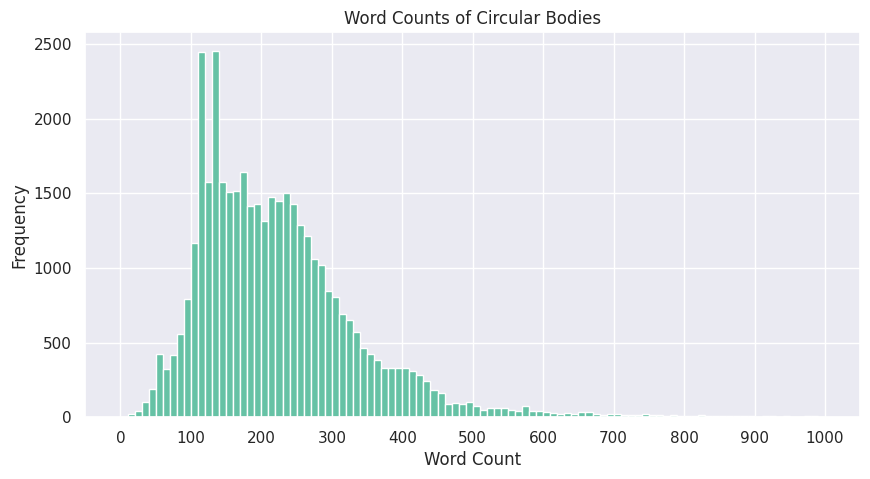

Number of circulars with > 1000 words: 318


In [ ]:
'''
Get word count distribution over all circulars.
'''
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()

counts=[]
for text in circular_bodies:
  counts.append(len(text.split()))

plt.figure(figsize=(10, 5))
plt.hist(counts, range=(0,1000), bins=100, color=sns.color_palette("Set2", 1))
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Counts of Circular Bodies")
plt.xticks(np.arange(0, 1001, 100))
plt.show()

counts_over_1000 = [count>1000 for count in counts]
print(f'Number of circulars with > 1000 words: {sum(counts_over_1000)}')

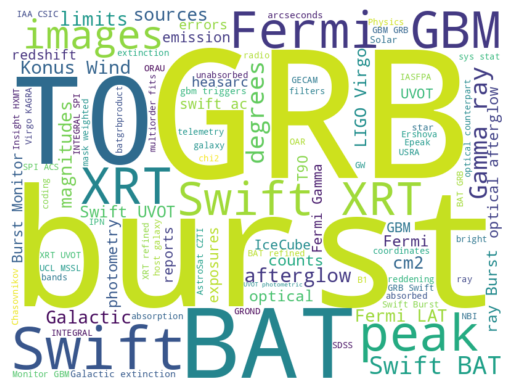

In [ ]:
'''
Create word cloud over all GCN circulars.
Includes bigrams and trigrams of words.
'''
from wordcloud import WordCloud

word_cloud = WordCloud(
    collocations = True,
    background_color = 'white',
    max_words=100,
    width=800,
    height=600,
    stopwords=new_stop_words).generate(' '.join(circular_bodies))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
'''
Print the list of words in the word cloud
'''

word_frequencies = word_cloud.words_
words = list(word_frequencies.keys())
for word in words:
  print(word)

GRB
burst
T0
BAT
Swift
XRT
Fermi GBM
peak
Swift XRT
images
Swift BAT
Gamma ray
degrees
afterglow
limits
Konus Wind
Galactic
magnitudes
sources
Fermi LAT
cm2
LIGO Virgo
Swift UVOT
Fermi
optical
ray Burst
counts
optical afterglow
T90
photometry
swift ac
Burst Monitor
emission
exposures
GBM
heasarc
reports
Fermi Gamma
UVOT
errors
redshift
IceCube
gbm triggers
star
arcseconds
Solar
Galactic extinction
B1
bright
unabsorbed
SPI ACS
extinction
coordinates
IASFPA
optical counterpart
Swift Burst
IAA CSIC
Physics
bands
Epeak
Monitor GBM
ray
SDSS
USRA
absorption
GW
INTEGRAL SPI
IPN
host galaxy
AstroSat CZTI
reddening
telemetry
chi2
galaxy
coding
BAT refined
absorbed
BAT GRB
GBM GRB
OAR
radio
sys stat
UCL MSSL
INTEGRAL
filters
GROND
NBI
mask weighted
GRB Swift
Virgo KAGRA
ORAU
GECAM
multiorder fits
XRT refined
Ershova
Chasovnikov
XRT UVOT
batgrbproduct
Insight HXMT
UVOT photometric


#Step 6: Embed GCN Circulars With The Default all-MiniLM-L6-v2

In [ ]:
'''
Embed our circulars using the base all-MiniLM-L6-v2 model.
'''
from sentence_transformers import SentenceTransformer

# Default model. Really fast, but only has context window of 256 tokens
model = SentenceTransformer("all-MiniLM-L6-v2")
minilm_l6_embeddings = model.encode(circular_bodies, show_progress_bar=True)
np.save('minilm_l6_embeddings.npy', minilm_l6_embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

#Step 7: Embedding Model Evaluation For Observation-Based Circular Classification

In [ ]:
'''
We will now test our topic models on a small pre-defined dataset.
We have gathered GCN circulars belonging to the following categories:
  -High-Energy Observations
  -Optical Observations
  -Radio
  -Neutrino
  -Gravitational Wave
In total we have 200 circulars in our dataset.
Our goal is to find the topic model that can correctly classify most of these circulars based on Zero-Shot Classification.
'''
from sklearn.model_selection import train_test_split

# Prepare dataset
high_energy = [25672, 26248, 14327, 14131, 6000, 29383, 17260, 10699, 19545, 17866, 9117, 8860, 6212, 26146, 7009, 7744, 10283, 22271, 2462, 28289, 25300, 24996, 3348, 26573, 11527, 20928, 29800, 28011, 12555, 32813, 23226, 33757, 2505, 23140, 13558, 12449, 23445, 22699, 13959, 22115]
optical = [28681, 22275, 21480, 3791, 5286, 2192, 31976, 23411, 18503, 23516, 31426, 31356, 33293, 17415, 31015, 598, 4738, 9761, 17736, 9628, 28161, 13557, 34651, 5615, 5065, 11329, 19277, 30221, 21931, 13710, 28226, 9179, 24256, 31394, 33941, 33098, 34473, 29604, 30112, 3199]
radio = [9047, 13903, 30542, 23753, 21933, 21395, 20787, 19610, 18548, 18345, 21058, 21057, 20981, 20105, 20453, 20313, 20344, 20328, 18978, 19310, 19607, 19848, 20116, 19606, 18454, 19966, 18620, 20428, 17178, 17284, 17104, 16593, 15783, 14863, 13813, 13743, 16603, 16295, 15395, 10019]
neutrino = [23605, 34933, 34838, 34798, 34163, 34166, 33876, 33589, 33430, 33850, 33128, 33122, 33097, 33040, 32741, 32523, 32499, 31681, 30468, 31128, 31476, 26718, 27642, 26812, 26716, 26707, 26623, 26620, 26189, 26181, 26049, 25836, 25842, 25693, 25225, 25210, 24865, 24854, 24573, 24410]
gw = [34895, 34857, 34801, 34799, 34775, 34692, 34728, 34605, 34337, 34264, 34206, 34173, 34968, 27358, 27278, 27193, 27042, 26906, 26675, 26543, 26513, 26641, 26413, 26334, 26303, 26288, 26254, 26250, 26182, 25883, 25876, 25871, 25829, 25814, 25707, 25554, 25442, 25324, 25296, 25012]

high_energy_train, high_energy_test = train_test_split(high_energy, test_size=0.2, random_state=0)
optical_train, optical_test = train_test_split(optical, test_size=0.2, random_state=0)
radio_train, radio_test = train_test_split(radio, test_size=0.2, random_state=0)
neutrino_train, neutrino_test = train_test_split(neutrino, test_size=0.2, random_state=0)
gw_train, gw_test = train_test_split(gw, test_size=0.2, random_state=0)

train_observation_labels = []
test_observation_labels = []

# Get Training Set
for circular in circulars:
  if circular["circularId"] in high_energy_train:
    train_observation_labels.append("High Energy Observations")
  elif circular["circularId"] in optical_train:
    train_observation_labels.append("Optical Observations")
  elif circular["circularId"] in radio_train:
    train_observation_labels.append("Radio Observations")
  elif circular["circularId"] in neutrino_train:
    train_observation_labels.append("Neutrinos")
  elif circular["circularId"] in gw_train:
    train_observation_labels.append("Gravitational Wave")
  else:
    train_observation_labels.append("")

# Get Test Set
for circular in circulars:
  if circular["circularId"] in high_energy_test:
    test_observation_labels.append("High Energy Observations")
  elif circular["circularId"] in optical_test:
    test_observation_labels.append("Optical Observations")
  elif circular["circularId"] in radio_test:
    test_observation_labels.append("Radio Observations")
  elif circular["circularId"] in neutrino_test:
    test_observation_labels.append("Neutrinos")
  elif circular["circularId"] in gw_test:
    test_observation_labels.append("Gravitational Wave")
  else:
    test_observation_labels.append("")

print(len(train_observation_labels))
print(len(test_observation_labels))
print(len(high_energy_train))
print(len(high_energy_test))
print(len(optical_train))
print(len(optical_test))
print(len(radio_train))
print(len(radio_test))
print(len(neutrino_train))
print(len(neutrino_test))
print(len(gw_train))
print(len(gw_test))

40506
40506
32
8
32
8
32
8
32
8
32
8


In [ ]:
'''
We will perform Zero-Shot Topic Modelling to match circulars to pre-defined cadidate labels.
We'll be using a cosine similarity with various thresholds to match topic labels to circulars.
For the circulars that don't match any of the labels above our threshold we perform regular Topic Modelling.
Finally, we calculate accuracy scores for each embedding model and cosine threshold based on our dataset.
'''
import pandas as pd
from umap import UMAP

embeddings_list = ["Base Model", "Epoch 1", "Epoch 2", "Epoch 3"]
accuracy_scores = pd.DataFrame(index=["Train", "Test"], columns=embeddings_list)

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

candidate_topics = ["High Energy Observations",
                    "Optical Observations",
                    "Radio Observations",
                    "Neutrinos",
                    "Gravitational Wave"]


In [ ]:
'''
Compute accuracy for all-MiniLM-L6-v2 embeddings on training set
'''
from bertopic import BERTopic

vectorizer_model = CountVectorizer()
embeddings = np.load("minilm_l6_embeddings.npy")
model = SentenceTransformer("all-MiniLM-L6-v2")
error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
topic_model = BERTopic(verbose=True,
                       umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.1, # Assign topic to each circular if it crosses threshold
                       embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])

score = 0
for i, label in enumerate(train_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Train", "Base Model"] = accuracy

2025-06-14 20:39:17,426 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-14 20:39:17,858 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-06-14 20:39:17,861 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-14 20:39:25,164 - BERTopic - Dimensionality - Completed ✓
2025-06-14 20:39:25,165 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-14 20:39:25,176 - BERTopic - Cluster - Completed ✓
2025-06-14 20:39:25,185 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-14 20:39:25,219 - BERTopic - Representation - Completed ✓
2025-06-14 20:39:25,242 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-14 20:39:25,268 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-14 20:39:25,273 - BERTopic - Dimensionality - Completed ✓
2025-06-14 20:39

Raw Score: 107
Raw Error: 53


In [ ]:
'''
Compute accuracy scores for base model on test set
'''

error_count=0

topic_model = BERTopic(verbose=True,
                      umap_model=umap_model,
                      vectorizer_model=vectorizer_model,
                      zeroshot_topic_list=candidate_topics,
                      zeroshot_min_similarity=0.1,
                      embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])

score = 0
for i, label in enumerate(test_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Test", "Base Model"] = accuracy

2025-06-14 20:39:33,483 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-14 20:39:33,660 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-06-14 20:39:33,665 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-14 20:39:33,731 - BERTopic - Dimensionality - Completed ✓
2025-06-14 20:39:33,732 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-14 20:39:33,737 - BERTopic - Cluster - Completed ✓
2025-06-14 20:39:33,739 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-14 20:39:33,793 - BERTopic - Representation - Completed ✓
2025-06-14 20:39:33,807 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-14 20:39:33,829 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-14 20:39:33,832 - BERTopic - Dimensionality - Completed ✓
2025-06-14 20:39

Raw Score: 26
Raw Error: 14


In [ ]:
accuracy_scores

,Base Model,Epoch 1,Epoch 2,Epoch 3
Train,66.875,NaN,NaN,NaN
Test,65.0,NaN,NaN,NaN


#Step 8: Contrastive Fine-Tuning On Labelled Dataset (Do Not Run If You're Not Training)

In [ ]:
'''
We will now fine-tune our sentence embedder model using Contrastive Loss.
The goal is to fine-tune our embeddings so that circulars belong to similar topics are embedded more closely,
while circulars belonging to dissimilar topics are embedded far away in the vector space.
Theoretically this should help improve our zero-shot topic modelling accuracy.
We'll be using the same Gravitational Wave + Counterpart circular dataset as before.
'''

# Prepare Dataset
event_dataset = []
for text, label in zip(circular_bodies, train_observation_labels):
  example = {}
  if label != "":
    example["text"] = text
    example["label"] = candidate_topics.index(label)
    event_dataset.append(example)

# Add label names to event dataset as well
for label in candidate_topics:
  example = {}
  example["text"] = label
  example["label"] = candidate_topics.index(label)
  event_dataset.append(example)

print(len(event_dataset))
unique_values = {d["label"] for d in event_dataset if "label" in d}
print(unique_values)

165
{0, 1, 2, 3, 4}


In [ ]:
# Prepare Similar Event Dataset
event_pair_dataset = []
for i in event_dataset:
  for j in event_dataset:
    # if i == j:
    #   continue
    example={}
    example["texts"] = [i["text"], j["text"]]
    if i["label"] == j["label"]:
      example["label"] = 1
    else:
      example["label"] = 0
    event_pair_dataset.append(example)

print(len(event_pair_dataset))

27225


In [ ]:
'''
Train for 1 epoch on the training set
'''
import torch
import random
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.old_fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=1,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_1")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

In [ ]:
'''
Train for 2 epochs on the training set
'''

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.old_fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=2,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_2")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

In [ ]:
'''
Train for 3 epochs on the training set
'''

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.old_fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=3,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_3")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27225 [00:00<?, ?it/s]

In [ ]:
# Get new all-MiniLM-L6-v2 embeddings
model_1 = SentenceTransformer("/content/tuned_mini_lm_1")
model_2 = SentenceTransformer("/content/tuned_mini_lm_2")
model_3 = SentenceTransformer("/content/tuned_mini_lm_3")

tuned_embeddings_1 = model_1.encode(circular_bodies, show_progress_bar=True)
tuned_embeddings_2 = model_2.encode(circular_bodies, show_progress_bar=True)
tuned_embeddings_3 = model_3.encode(circular_bodies, show_progress_bar=True)

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

In [ ]:
'''
Compute training accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,4):
  embeddings = eval(f"tuned_embeddings_{i}")
  model = eval(f"model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(train_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Train", epoch] = accuracy

2025-06-15 00:27:54,814 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-15 00:27:55,089 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-15 00:27:55,112 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:27:55,115 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:27:55,264 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:27:55,278 - BERTopic - Cluster - Completed ✓
2025-06-15 00:27:55,288 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:02,831 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:03,260 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:03,261 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model
2025-06-15 00:28:03,306 - BERTopic - Zeroshot Step 1 - Finding documents that

Raw Score for Epoch 1: 160
Raw Error for Epoch 1: 0


2025-06-15 00:28:03,559 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-15 00:28:03,589 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:28:03,592 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:28:03,787 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:28:03,801 - BERTopic - Cluster - Completed ✓
2025-06-15 00:28:03,811 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:12,120 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:12,530 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:12,531 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model
2025-06-15 00:28:12,567 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-15 00:28:12,757 - BERTopic - Zeroshot Step 2 - Clustering documents t

Raw Score for Epoch 2: 160
Raw Error for Epoch 2: 0


2025-06-15 00:28:12,783 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:28:12,789 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:28:12,924 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:28:12,940 - BERTopic - Cluster - Completed ✓
2025-06-15 00:28:12,951 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:21,434 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:21,851 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:21,851 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model


Raw Score for Epoch 3: 160
Raw Error for Epoch 3: 0


In [ ]:
'''
Compute test accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,4):
  embeddings = eval(f"tuned_embeddings_{i}")
  model = eval(f"model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(test_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Test", epoch] = accuracy

2025-06-15 00:28:21,897 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-15 00:28:22,084 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-15 00:28:22,109 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:28:22,112 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:28:22,212 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:28:22,226 - BERTopic - Cluster - Completed ✓
2025-06-15 00:28:22,237 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:30,542 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:31,206 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:31,207 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model
2025-06-15 00:28:31,242 - BERTopic - Zeroshot Step 1 - Finding documents that

Raw Score for Epoch 1: 36
Raw Error for Epoch 1: 4


2025-06-15 00:28:31,455 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:28:31,459 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:28:31,546 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:28:31,577 - BERTopic - Cluster - Completed ✓
2025-06-15 00:28:31,588 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:39,240 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:39,627 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:39,628 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model
2025-06-15 00:28:39,663 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-15 00:28:39,848 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...


Raw Score for Epoch 2: 35
Raw Error for Epoch 2: 5


2025-06-15 00:28:39,873 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:28:39,877 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:28:39,957 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:28:39,972 - BERTopic - Cluster - Completed ✓
2025-06-15 00:28:39,981 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:28:48,473 - BERTopic - Representation - Completed ✓
2025-06-15 00:28:48,899 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:28:48,900 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model


Raw Score for Epoch 3: 34
Raw Error for Epoch 3: 6


In [ ]:
accuracy_scores

,Base Model,Epoch 1,Epoch 2,Epoch 3
Train,66.875,100.0,100.0,100.0
Test,65.0,90.0,87.5,85.0


In [ ]:
'''
Create latex table for accuracy scores
'''

accuracy_latex_table = accuracy_scores.to_latex(float_format="%.2f")
accuracy_latex_table

'\\begin{tabular}{lllll}\n\\toprule\n & Base Model & Epoch 1 & Epoch 2 & Epoch 3 \\\\\n\\midrule\nTrain & 66.88 & 100.00 & 100.00 & 100.00 \\\\\nTest & 65.00 & 90.00 & 87.50 & 85.00 \\\\\n\\bottomrule\n\\end{tabular}\n'

#Step 9: Zero-Shot Topic Modelling For Observation-Based Circular Classification

In [ ]:
# Get new all-MiniLM-L6-v2 embeddings
model_1 = SentenceTransformer("/content/tuned_mini_lm_1")
tuned_embeddings_1 = model_1.encode(circular_bodies, show_progress_bar=True)

Batches:   0%|          | 0/1266 [00:00<?, ?it/s]

In [ ]:
'''
We'll now perform topic modelling again but with Zero-Shot enabled.
We will use our fine-tuned all-MiniLM-L6-v2 model for this which was tuned for 1 epoch on the gravitational wave dataset.
We attempt to fit our topics into pre-defined candidate labels using zero-shot topic modelling.
'''
candidate_topics = ["High Energy Observations",
                    "Optical Observations",
                    "Radio Observations",
                    "Neutrinos",
                    "Gravitational Wave"]

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       embedding_model=model_1,
                       umap_model=umap_model,
                       min_topic_size=100,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.1)

topics, probs = topic_model.fit_transform(circular_bodies, tuned_embeddings_1)
topic_labels = [value for key, value in topic_model.topic_labels_.items()]
topic_model.set_topic_labels(topic_labels)

freq = topic_model.get_topic_info()
freq.head()

2025-06-15 00:45:27,928 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-06-15 00:45:28,213 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-06-15 00:45:28,233 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 00:45:28,239 - BERTopic - Dimensionality - Completed ✓
2025-06-15 00:45:28,459 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 00:45:28,486 - BERTopic - Cluster - Completed ✓
2025-06-15 00:45:28,501 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-15 00:45:37,416 - BERTopic - Representation - Completed ✓
2025-06-15 00:45:37,838 - BERTopic - Zeroshot Step 2 - Completed ✓
2025-06-15 00:45:37,838 - BERTopic - Zeroshot Step 3 - Combining clustered topics with the zeroshot model


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,19637,Optical Observations,Optical Observations,"[the, of, master, and, al, et, gcn, in, we, 18]",[GROND observations of GRB170604AP. Schady (MP...
1,1,17489,High Energy Observations,High Energy Observations,"[the, of, is, and, swift, grb, at, to, with, in]",[GRB 250312A: Swift detection of a burstA. Mel...
2,2,1368,Radio Observations,Radio Observations,"[the, radio, of, ghz, at, gcn, and, we, on, grb]",[Radio detection of GRB 071003 with the VLAP. ...
3,3,1170,Neutrinos,Neutrinos,"[icecube, the, neutrino, of, in, at, event, fo...",[IceCube-241006A: Upper limits from a search f...
4,4,842,Gravitational Wave,Gravitational Wave,"[the, ligo, virgo, is, and, sky, of, candidate...",[LIGO/Virgo/KAGRA S241225c: Identification of ...


In [ ]:
'''
Create observation-based topic csv file
'''
from datetime import datetime

circular_topic_df = pd.DataFrame()
circular_topic_df["Circular ID"] = [item["circularId"] for item in circulars]
circular_topic_df["Subject"] = [item["subject"] for item in circulars]
circular_topic_df["Date"] = [datetime.utcfromtimestamp(item["createdOn"]/1000) for item in circulars]
circular_topic_df["Label"] = [topic_model.topic_labels_[i] for i in topics]

# Sort by Circular IDs
circular_topic_df = circular_topic_df.sort_values(by="Circular ID")

circular_topic_df.head(10)

,Circular ID,Subject,Date,Label
3,-4.0,GRB 970228: Keck/LRIS Optical Observations,1997-08-14,Optical Observations
2,-3.0,GRB 970828: Palomar Observations,1997-09-02,Optical Observations
1,-2.0,RXTE Observations of SGR 1814-13,1997-09-13,High Energy Observations
0,-1.0,Possible new SGR from US Naval Observatory,1997-09-12,High Energy Observations
4,0.0,IRAS 18119-1342 and the possible new SGR,1997-09-23,Optical Observations
5,1.0,GRB 970925: BATSE Localization,1997-09-26,Optical Observations
11060,2.0,GRB 971024: USNO Observations,1997-10-26,Optical Observations
22119,3.0,GRB 971024: KPNO Optical Observations,1997-10-26,Optical Observations
33220,4.0,GRB 971024: Refined analysis by USNOFS Observ...,1997-10-27,Optical Observations
34956,5.0,GRB 971024: KPNO Optical Observations Summary,1997-10-26,Optical Observations


In [ ]:
circular_topic_df.to_csv('observation_based_topics.csv', index=False)

In [ ]:
'''
Apply TSNE to reduce the dimensionality of the embeddings and visualize the clusters.
'''
from sklearn.manifold import TSNE
import plotly.graph_objects as go

reduced_embeddings = TSNE(n_components=2, n_jobs=1, random_state=0, verbose=2).fit_transform(tuned_embeddings_1)

fig = go.Figure()
tsne_df = pd.DataFrame()
tsne_df["x"], tsne_df["y"] = reduced_embeddings[:, 0], reduced_embeddings[:, 1]
tsne_df["topics"] = [topic_model.topic_labels_[i] for i in topics]

for label in list(topic_model.topic_labels_.values()):
  sub_df = tsne_df.loc[tsne_df["topics"] == label]
  fig.add_trace(
    go.Scattergl(
      x=sub_df["x"],
      y=sub_df["y"],
      mode="markers",
      name=str(label[label.find('_')+1:]) + " (" + str(sub_df.shape[0]) + ")",
    )
  )

fig.update_traces(
  marker=dict(
    size=5,
    opacity=0.5,
  )
)

fig.update_layout(
  title={
    'text': "<b>General Coordinates Network (GCN): Observation-Based Topic Clusters</b>",
    'x': 0.5,
    'xanchor': 'center'
  },
  width=1200,
  height=800,
  legend_title_text="Topics (Circular Counts)",
  legend=dict(
    x=1.05,
    y=1,
    traceorder='normal',
    bgcolor='rgba(0,0,0,0)',
    bordercolor='rgba(0,0,0,0)',
    font=dict(size=16)
  ),
  xaxis=dict(
    showticklabels=False
  ),
  yaxis=dict(
    showticklabels=False
  )
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40506 samples in 0.006s...
[t-SNE] Computed neighbors for 40506 samples in 42.557s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40506
[t-SNE] Computed conditional probabilities for sample 2000 / 40506
[t-SNE] Computed conditional probabilities for sample 3000 / 40506
[t-SNE] Computed conditional probabilities for sample 4000 / 40506
[t-SNE] Computed conditional probabilities for sample 5000 / 40506
[t-SNE] Computed conditional probabilities for sample 6000 / 40506
[t-SNE] Computed conditional probabilities for sample 7000 / 40506
[t-SNE] Computed conditional probabilities for sample 8000 / 40506
[t-SNE] Computed conditional probabilities for sample 9000 / 40506
[t-SNE] Computed conditional probabilities for sample 10000 / 40506
[t-SNE] Computed conditional probabilities for sample 11000 / 40506
[t-SNE] Computed conditional probabilities for sample 12000 / 40506
[t-SNE] Computed conditional probabilities for sa

In [ ]:
# Display a Similarity Matrix for all Topics
topic_model.visualize_heatmap(width=950, height=650, custom_labels=True)

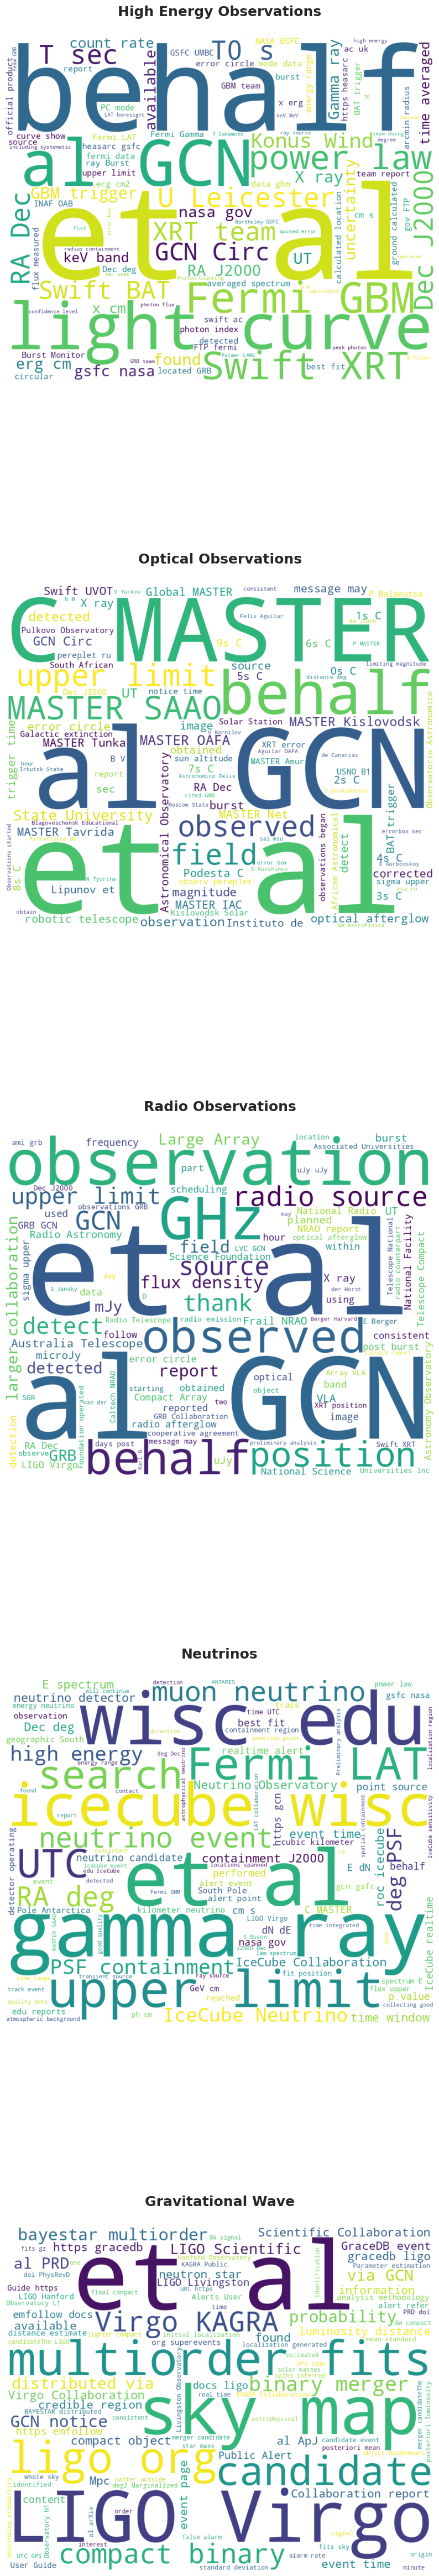

In [ ]:
'''
Create word cloud over our candidate topics
'''

fig, axs = plt.subplots(len(candidate_topics), 1, figsize=(10, 60))

# Join all documents of a candidate topic together and generate word cloud
for topic_num, ax in enumerate(axs):
  word_cloud = WordCloud(
        collocations=True,
        background_color='white',
        max_words=100,
        width=1000,
        height=800).generate(' '.join([text for i, text in enumerate(circular_bodies) if topic_model.topic_labels_[topics[i]] == candidate_topics[topic_num]]))

  ax.imshow(word_cloud, interpolation='bilinear')
  ax.set_title(candidate_topics[topic_num], fontsize=18, fontweight="bold", y=1.05)
  ax.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

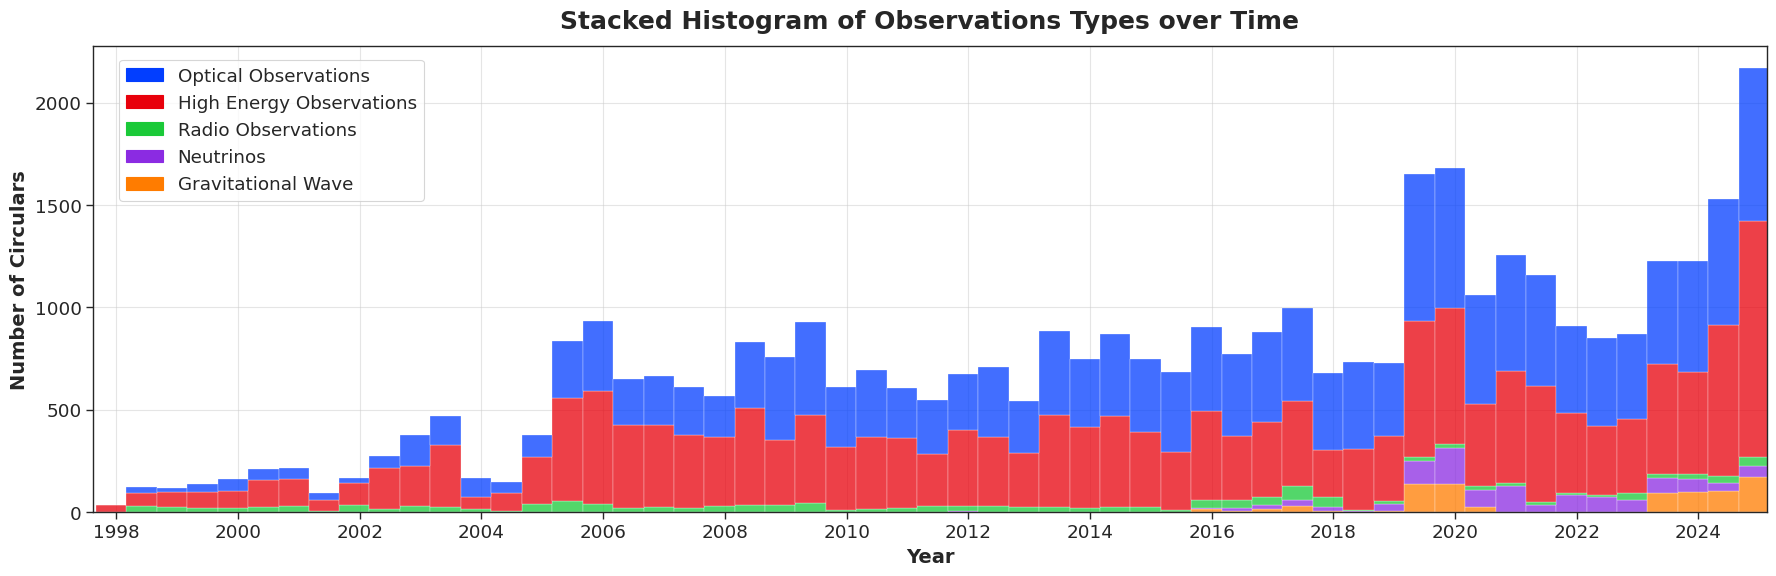

In [ ]:
'''
We will now perform Trend Analysis over our Topic Clusters.
'''
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from datetime import datetime

num_topics = len(freq)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(18, 6))
custom_colors = ['#023eff', '#e8000b', '#1ac938', '#8b2be2', '#ff7c00']
custom_palette =  sns.color_palette(custom_colors)

all_topic_dates = []
all_dates = [] # List to store all dates

# Iterate over all timestamps and check their respective document's topic
for i, time_stamp in enumerate(time_stamps):
  if time_stamp == 0: # Discard invalid dates
      continue
  date = datetime.utcfromtimestamp(time_stamp/1000)
  topic = topic_model.topic_labels_[topics[i]]
  all_topic_dates.append({'Date': date, 'Topic': topic})
  all_dates.append(date)

topic_dates_df = pd.DataFrame(all_topic_dates)
my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')
sns.histplot(topic_dates_df,
             x='Date',
             hue='Topic',
             multiple="stack",
             bins=mdates.date2num(my_bins),
             alpha=0.75,
             linewidth=0.2,
             palette=custom_palette)

# Calculate the number of 6-month intervals between start and end dates
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

# Calculate the adjusted end date based on the number of intervals
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

plt.xlim(start_date, adjusted_end_date)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Stacked Histogram of Observations Types over Time", fontsize=18, fontweight="bold", y=1.02)
plt.grid(axis="both", linestyle="-", alpha=0.5)
handles = [Patch(color=custom_colors[i], label=topic_model.topic_labels_[i]) for i in range(len(custom_colors))]
plt.legend(handles=handles, bbox_to_anchor=(0.01, 0.99), loc='upper left')

plt.tight_layout()
plt.show()